数据样本分析
画出数据量条形图
画出图像分辨率散点图

In [1]:
import os
import PIL.Image as Image
import matplotlib.pyplot as plt
import numpy as np
import cv2

dataset_root_path = "dataset"

# Image Size

Images need to be resize to unified 

C:\Users\jingh\anaconda3\envs\d2l\lib\site-packages\PIL\TiffImagePlugin.py:858: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


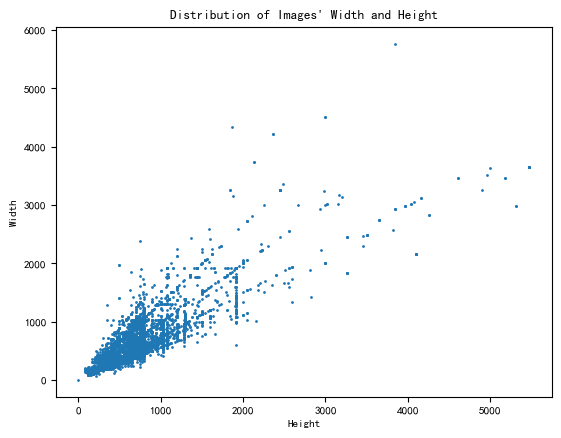

In [29]:
def plot_resolution(dataset_root_path):
    img_size_list = [] # all images' size
    for root, dirs, files in os.walk(dataset_root_path):
        for file_i in files:
            file_i_full_path = os.path.join(root, file_i) # dataset\其他垃圾_一次性杯\img_一次性杯子_1.jpeg
            img_i = Image.open(file_i_full_path)
            img_i_size = img_i.size # get tuple (width, height) of a single image (1024, 682), (800, 800)...
            img_size_list.append(img_i_size)
    # print(img_size_list) # [(1024, 682), (800, 800), (2448, 3264),...]
    # print(len(img_size_list)) # 12094
    
    width_list = [img_size_list[i][0] for i in range(len(img_size_list))]
    height_list = [img_size_list[i][1] for i in range(len(img_size_list))]
    
    plt.scatter(width_list, height_list, s=1)
    plt.xlabel("Height")
    plt.ylabel("Width")
    plt.title("Distribution of Images' Width and Height")
    plt.show()

plot_resolution(dataset_root_path)

## 删除尺寸过大和长宽比例大于2的图片

In [ ]:
min = 200
max = 2000
ratio = 0.5

delete_list = []
for root, _, files in os.walk(dataset_root_path):
    for file_i in files:
        file_i_full_path = os.path.join(root, file_i) # dataset\其他垃圾_一次性杯\img_一次性杯子_1.jpeg
        img_i = Image.open(file_i_full_path)
        img_i_size = img_i.size # get tuple (width, height) of a single image (1024, 682), (800, 800)...
        
        # Delete size < min
        if img_i_size[0] < min or img_i_size[1] < min:
            delete_list.append(file_i_full_path)
            
        # Delete size > max
        if img_i_size[0] > max or img_i_size[1] > max:
            delete_list.append(file_i_full_path)
        
        # Delete ratio too much
        long = img_i_size[0] if img_i_size[0] > img_i_size[1] else img_i_size[1]
        short = img_i_size[0] if img_i_size[0] < img_i_size[1] else img_i_size[1]
        
        if (short / long) < ratio:
            delete_list.append(file_i_full_path)
            
for file_i in delete_list:
    try:
        print("正在删除",file_i)
        os.remove(file_i)
    except:
        pass

# Distribution of categories

mean =  219.8909090909091


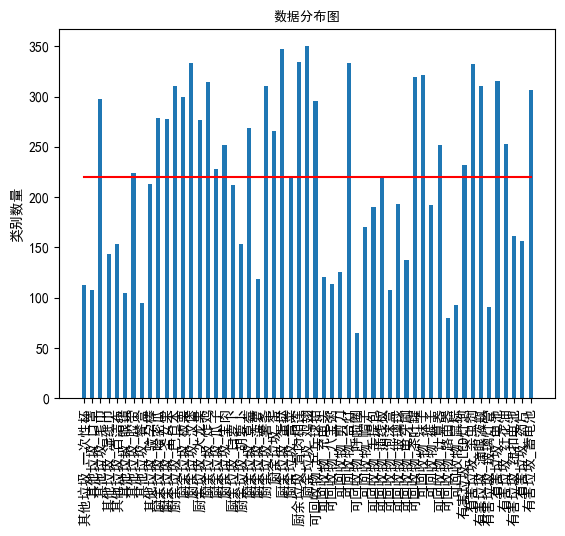

In [2]:
def plot_bar(dataset_root_path):

    file_name_list = []
    file_num_list = []
    for root, dirs, files in os.walk(dataset_root_path):
        if len(dirs) != 0:
            for dir_i in dirs:
                file_name_list.append(dir_i)
        file_num_list.append(len(files))

    file_num_list = file_num_list[1:]
    # 求均值，并把均值以横线形式显示出来
    mean = np.mean(file_num_list)
    print("mean = ", mean)

    bar_positions = np.arange(len(file_name_list))

    fig, ax = plt.subplots()  # 定义画的区间和子画
    ax.bar(bar_positions, file_num_list, 0.5)  # 画柱图，参数：柱间的距离，柱的值，柱的宽度

    ax.plot(bar_positions, [mean for i in bar_positions], color="red")  # 显示平均值

    plt.rcParams["font.sans-serif"] = ["SimHei"]  # 设置中文字体
    plt.rcParams["font.size"] = 8
    plt.rcParams["axes.unicode_minus"] = False  # 该语句解决图像中的“-”负号的乱码问题

    ax.set_xticks(bar_positions)  # 设置x轴的刻度
    ax.set_xticklabels(file_name_list, rotation=90)  # 设置x轴的标签
    ax.set_ylabel("类别数量")
    ax.set_title("数据分布图")
    plt.show()

plot_bar(dataset_root_path)

## 数据增强

* 水平翻转
* 垂直翻转

In [9]:
# 水平翻转
def Horizontal(image):
    return cv2.flip(image, 1, dst=None)

def Vertical(image):
    return cv2.flip(image, 0, dst=None)

from_root = r"dataset"
save_root = r"enhance_dataset"

threshold = 200

for root, _, files in os.walk(from_root):
    for file_i in files:
        file_i_full_path = os.path.join(root, file_i) # dataset\其他垃圾_一次性杯\img_一次性杯子_1.jpeg
        
        split = os.path.split(file_i_full_path)
        dir_loc= os.path.split(split[0])[1]
        save_path = os.path.join(save_root, dir_loc) # 把每个文件对应的文件夹和enhance_dataset拼接
#         print(file_i_full_path)
#         print(save_path)

        if os.path.isdir(save_path) == False:
            os.makedirs(save_path)
        
        img_i = cv2.imdecode(np.fromfile(file_i_full_path, dtype=np.uint8), -1) # read image因为路径包含中文，用cv2.imdecode
        cv2.imencode('.jpg', img_i)[1].tofile(os.path.join(save_path, file_i[:-5] + "_original.jpg")) # save image
        
        # 判断文件夹内文件的数量是否小于threshold，是的话进行图像增强
        if len(files) < threshold:
            img_horizontal = Horizontal(img_i)
            cv2.imencode('.jpg', img_horizontal)[1].tofile(os.path.join(save_path, file_i[:5] + "_horizontal.jpg"))
            
            img_vertical = Vertical(img_i)
            cv2.imencode('.jpg', img_vertical)[1].tofile(os.path.join(save_path, file_i[:5] + "_vertical.jpg"))
        else:
            pass
        

# 图像3通道归一化

## 图像均值和方差

In [14]:
from torchvision.datasets import ImageFolder
import torch
from torchvision import transforms as T
from tqdm import tqdm

In [15]:
transform = T.Compose([
    T.RandomResizedCrop(224),
    T.ToTensor(),
])

def getStat(train_data):
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=False, num_workers=0, pin_memory=True)
    mean = torch.zeros(3)
    std = torch.zeros(3)
    for X, _ in tqdm(train_loader):
        for d in range(3):
            mean[d] += X[:, d, :, :].mean() # [N, C, H, W]
            std[d] += X[:, d, :, :].std()
    mean.div_(len(train_data))
    std.div_(len(train_data))
    return list(mean.numpy()), list(std.numpy())

train_dataset = ImageFolder(root=r'enhance_dataset', transform=transform)
print(getStat(train_dataset))

100%|████████████████████████████████████████████████████████████████████████████| 12142/12142 [03:30<00:00, 57.69it/s]

([0.6421196, 0.5595028, 0.48427588], [0.21218358, 0.22349793, 0.2313148])
